<a href="https://colab.research.google.com/github/divya-r-kamat/EfficientMnist-Under20K/blob/main/EfficientMnistNN_Iter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNist Neural Network

The goal is to achieve 99.4% validation/test accuracy, with less than 20k Parameters and in 20 epochs | Added BatchNorm

### Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

### Model Architecture

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)    # RF = 3
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 10, kernel_size=3)   # RF = 5
        self.bn2 = nn.BatchNorm2d(10)

        self.conv3 = nn.Conv2d(10, 16, kernel_size=3)  # RF = 7
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 8, kernel_size=1)   # RF = 7
        self.bn4 = nn.BatchNorm2d(8)

        # MaxPool2d will follow conv4 in forward() → RF = 8, jump = 2

        self.conv5 = nn.Conv2d(8, 10, kernel_size=3)   # RF = 12
        self.bn5 = nn.BatchNorm2d(10)

        self.conv6 = nn.Conv2d(10, 16, kernel_size=3)  # RF = 16
        self.bn6 = nn.BatchNorm2d(16)

        self.conv7 = nn.Conv2d(16, 28, kernel_size=3)  # RF = 20

        self.fc1 = nn.Linear(5 * 5 * 28, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # RF = 3
        x = F.relu(self.bn2(self.conv2(x)))  # RF = 5
        x = F.relu(self.bn3(self.conv3(x)))  # RF = 7

        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), 2)  # RF = 8

        x = F.relu(self.bn5(self.conv5(x)))  # RF = 12
        x = F.relu(self.bn6(self.conv6(x)))  # RF = 16
        x = F.relu(self.conv7(x))            # RF = 20

        x = x.view(-1, 5 * 5 * 28)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

### Check if CUDA is available and display model parameters


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3           [-1, 10, 24, 24]             730
       BatchNorm2d-4           [-1, 10, 24, 24]              20
            Conv2d-5           [-1, 16, 22, 22]           1,456
       BatchNorm2d-6           [-1, 16, 22, 22]              32
            Conv2d-7            [-1, 8, 22, 22]             136
       BatchNorm2d-8            [-1, 8, 22, 22]              16
            Conv2d-9             [-1, 10, 9, 9]             730
      BatchNorm2d-10             [-1, 10, 9, 9]              20
           Conv2d-11             [-1, 16, 7, 7]           1,456
      BatchNorm2d-12             [-1, 16, 7, 7]              32
           Conv2d-13             [-1, 28, 5, 5]           4,060
           Linear-14                   

### Print model architecture

In [4]:
print(model)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(16, 28, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=700, out_features=10, bias=True)
)


### Load train and test data, and apply transformations

In [5]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                    transforms.Resize((28, 28)),
                    transforms.RandomRotation((-15., 15.), fill=0),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])),batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.24MB/s]


In [6]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

### Training Loop

In [7]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Train loss={loss.item():0.4f} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    train_losses.append(loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Model training

In [8]:

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Epoch 1


Train loss=0.0812 batch_id=468 Accuracy=91.65: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]


Test set: Average loss: 0.0613, Accuracy: 9800/10000 (98.00%)

Epoch 2


Train loss=0.0343 batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]


Test set: Average loss: 0.0437, Accuracy: 9863/10000 (98.63%)

Epoch 3


Train loss=0.0932 batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]


Test set: Average loss: 0.0371, Accuracy: 9877/10000 (98.77%)

Epoch 4


Train loss=0.0536 batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]


Test set: Average loss: 0.0463, Accuracy: 9858/10000 (98.58%)

Epoch 5


Train loss=0.0372 batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:23<00:00, 19.81it/s]


Test set: Average loss: 0.0262, Accuracy: 9905/10000 (99.05%)

Epoch 6


Train loss=0.0616 batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:23<00:00, 19.76it/s]


Test set: Average loss: 0.0248, Accuracy: 9920/10000 (99.20%)

Epoch 7


Train loss=0.0111 batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:24<00:00, 19.47it/s]


Test set: Average loss: 0.0258, Accuracy: 9910/10000 (99.10%)

Epoch 8


Train loss=0.0049 batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


Test set: Average loss: 0.0252, Accuracy: 9926/10000 (99.26%)

Epoch 9


Train loss=0.0317 batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]


Test set: Average loss: 0.0233, Accuracy: 9917/10000 (99.17%)

Epoch 10


Train loss=0.0473 batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

Epoch 11


Train loss=0.0283 batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]


Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

Epoch 12


Train loss=0.1132 batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

Epoch 13


Train loss=0.0037 batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:24<00:00, 19.49it/s]


Test set: Average loss: 0.0222, Accuracy: 9942/10000 (99.42%)

Epoch 14


Train loss=0.0488 batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.42it/s]


Test set: Average loss: 0.0221, Accuracy: 9925/10000 (99.25%)

Epoch 15


Train loss=0.0181 batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]


Test set: Average loss: 0.0236, Accuracy: 9934/10000 (99.34%)

Epoch 16


Train loss=0.0249 batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]


Test set: Average loss: 0.0156, Accuracy: 9950/10000 (99.50%)

Epoch 17


Train loss=0.0050 batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]


Test set: Average loss: 0.0157, Accuracy: 9950/10000 (99.50%)

Epoch 18


Train loss=0.0025 batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]


Test set: Average loss: 0.0151, Accuracy: 9952/10000 (99.52%)

Epoch 19


Train loss=0.0038 batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]


Test set: Average loss: 0.0149, Accuracy: 9955/10000 (99.55%)

Epoch 20


Train loss=0.0093 batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:23<00:00, 19.68it/s]


Test set: Average loss: 0.0148, Accuracy: 9959/10000 (99.59%)



### Plots

Text(0.5, 1.0, 'Test Accuracy')

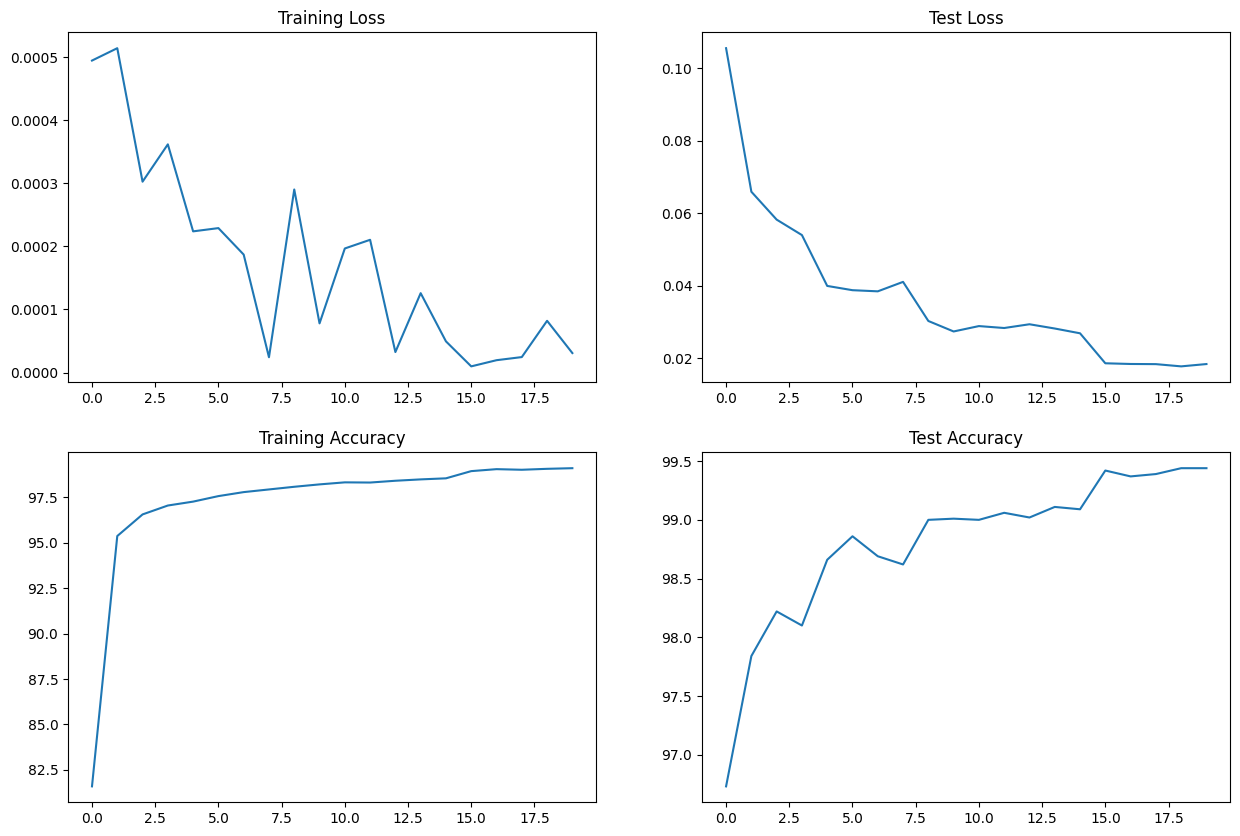

In [9]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([loss.cpu().item() for loss in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")